In [1]:
# https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d
# https://github.com/CamDavidsonPilon/lifelines/blob/master/examples/Modelling%20time-lagged%20conversion%20rates.ipynb

In [1]:
# !pip install lifelines

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import autograd.numpy as np
from autograd.scipy.special import expit, logit
import pandas as pd
plt.style.use('bmh')

from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame
print(df.head())

      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


In [3]:
T = df['T']
E = df['E']

In [4]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 163 total observations, 7 right-censored observations>

In [5]:
groups = df['group']
ix = (groups == 'miR-137')

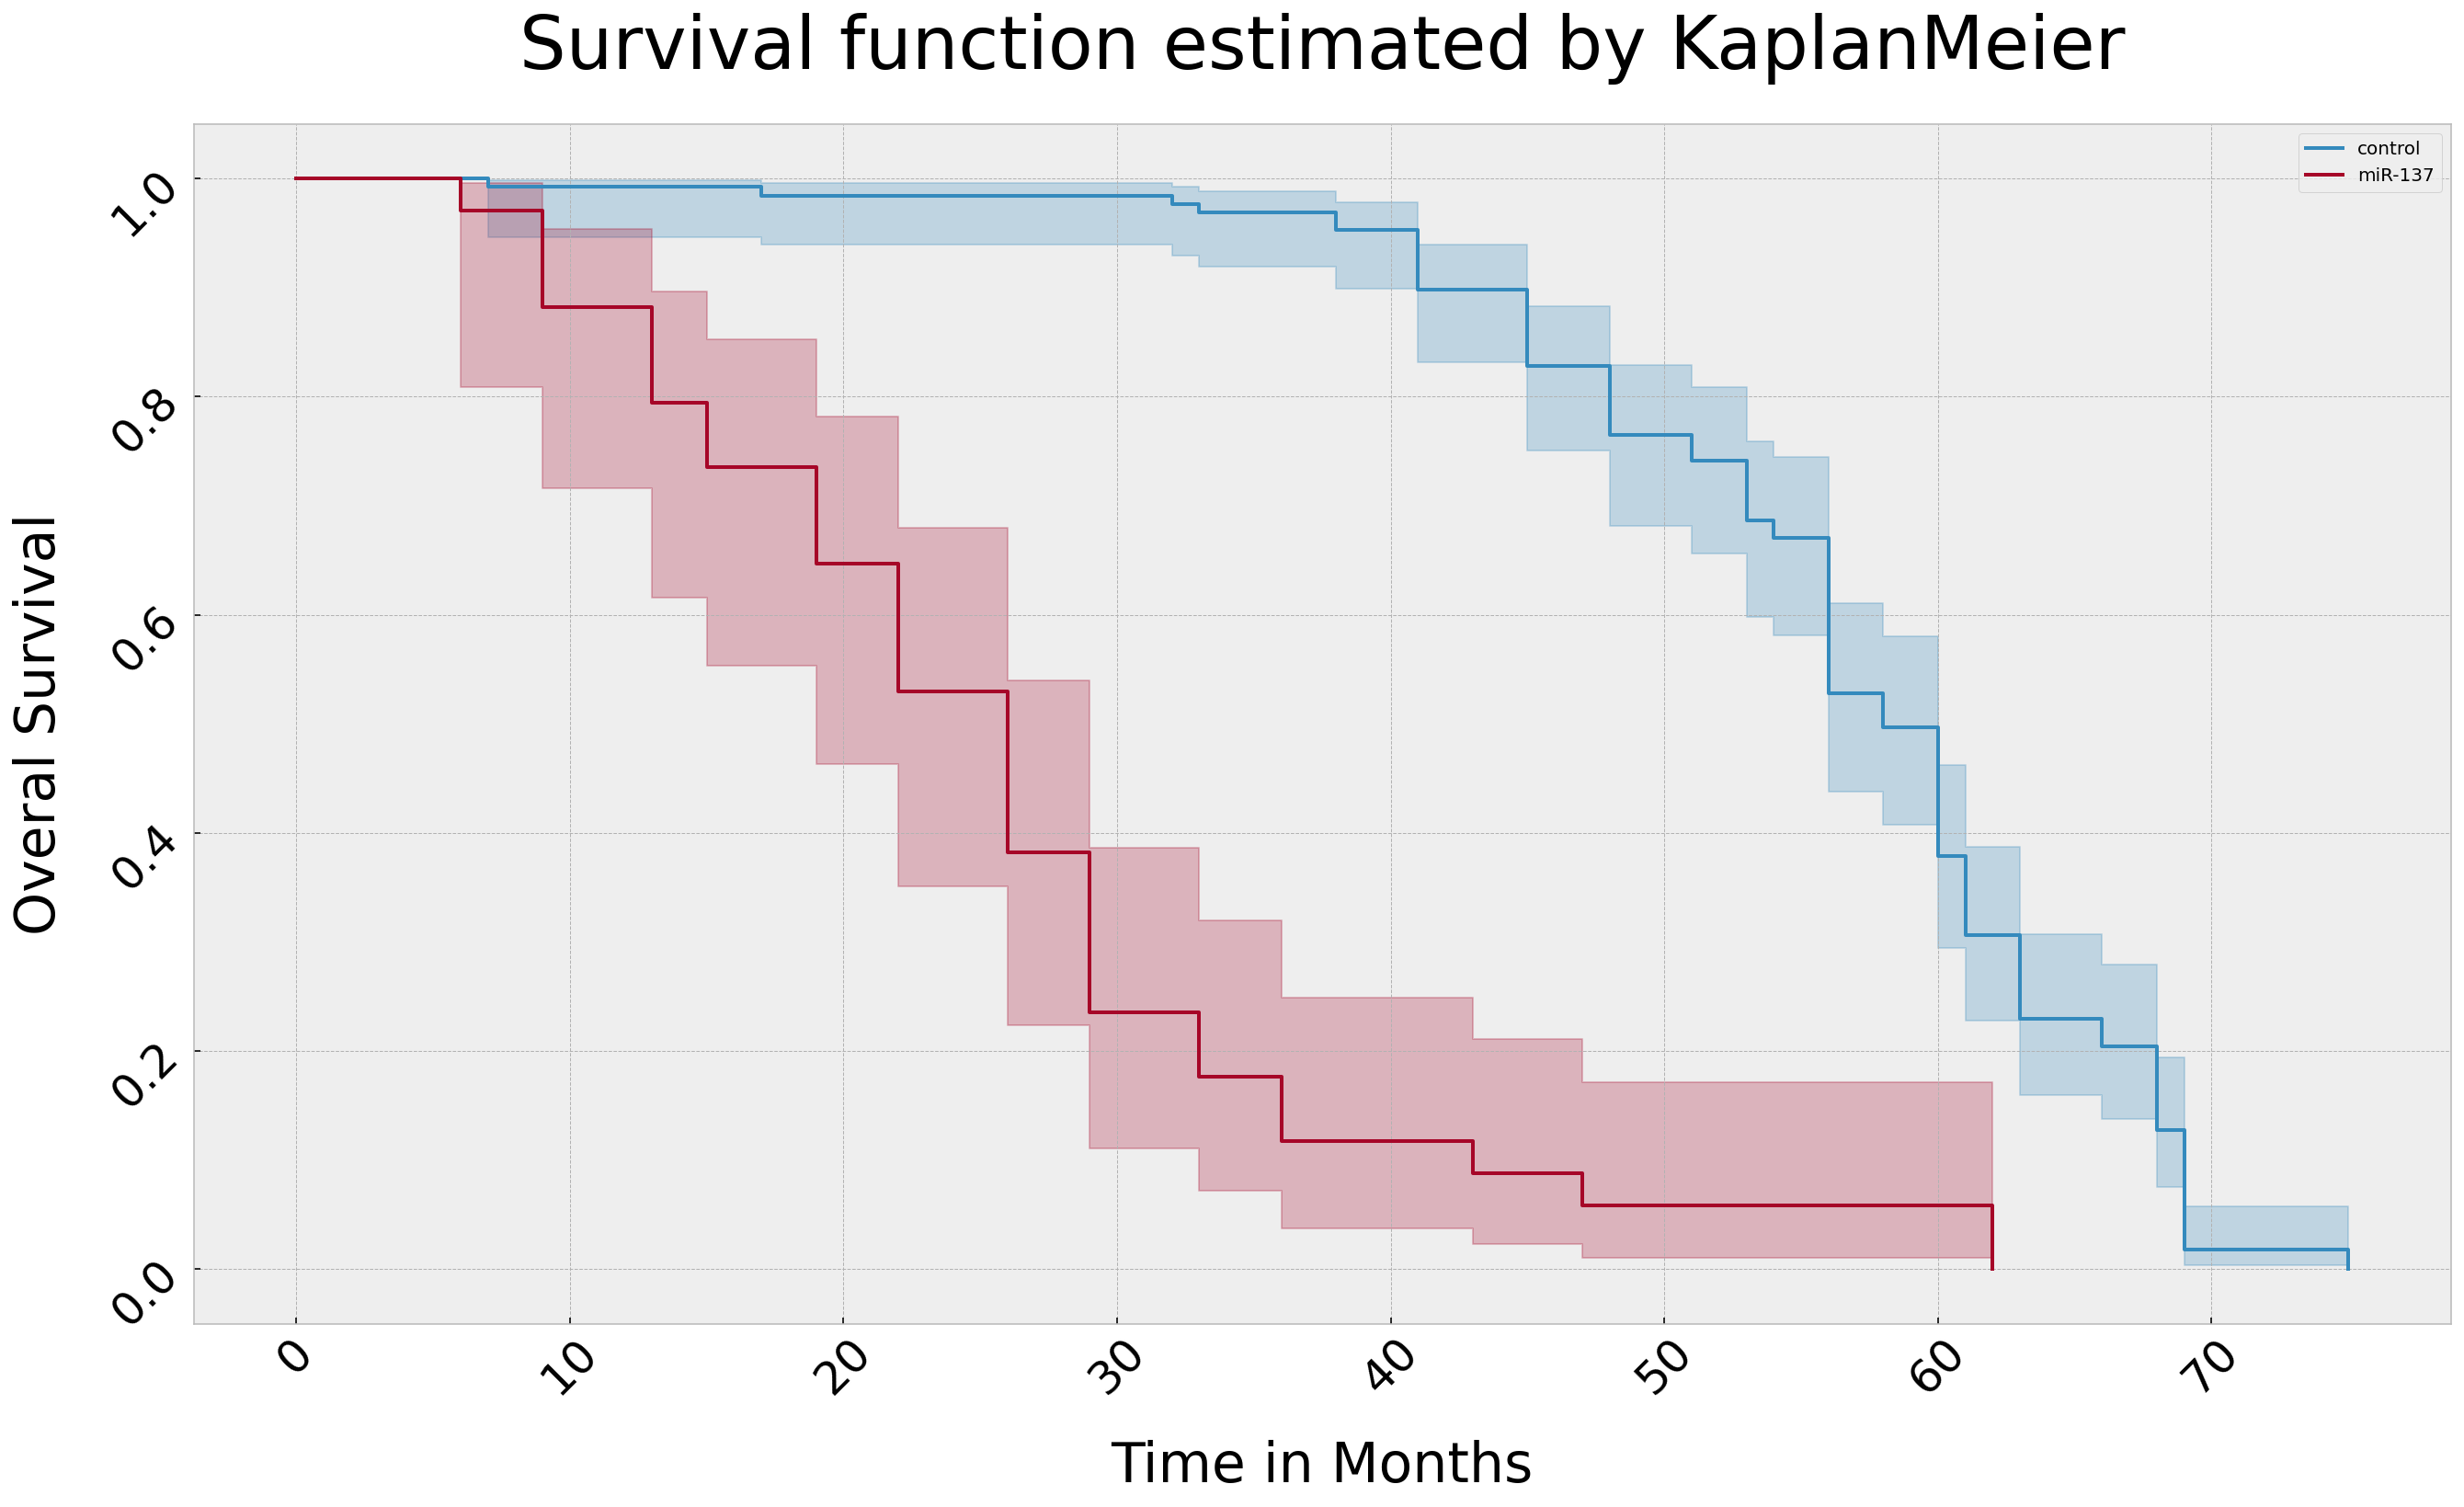

<Figure size 1584x864 with 0 Axes>

In [6]:
kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot_survival_function(figsize = (22, 12))

kmf.fit(T[ix], E[ix], label='miR-137')

plt.figure(figsize=(22,12))

ax = kmf.plot_survival_function(ax=ax)

# title and labels, setting initial sizes
ax.set_title('Survival function estimated by KaplanMeier', fontsize=40, pad=30)
ax.set_xlabel('Time in Months', fontsize=30, labelpad=20); ax.set_ylabel('Overal Survival', fontsize=30, labelpad=20)
ax.tick_params(axis="x", labelsize=25, rotation=45); ax.tick_params(axis="y", labelsize=25, rotation=45)

AttributeError: 'tuple' object has no attribute 'set_title'

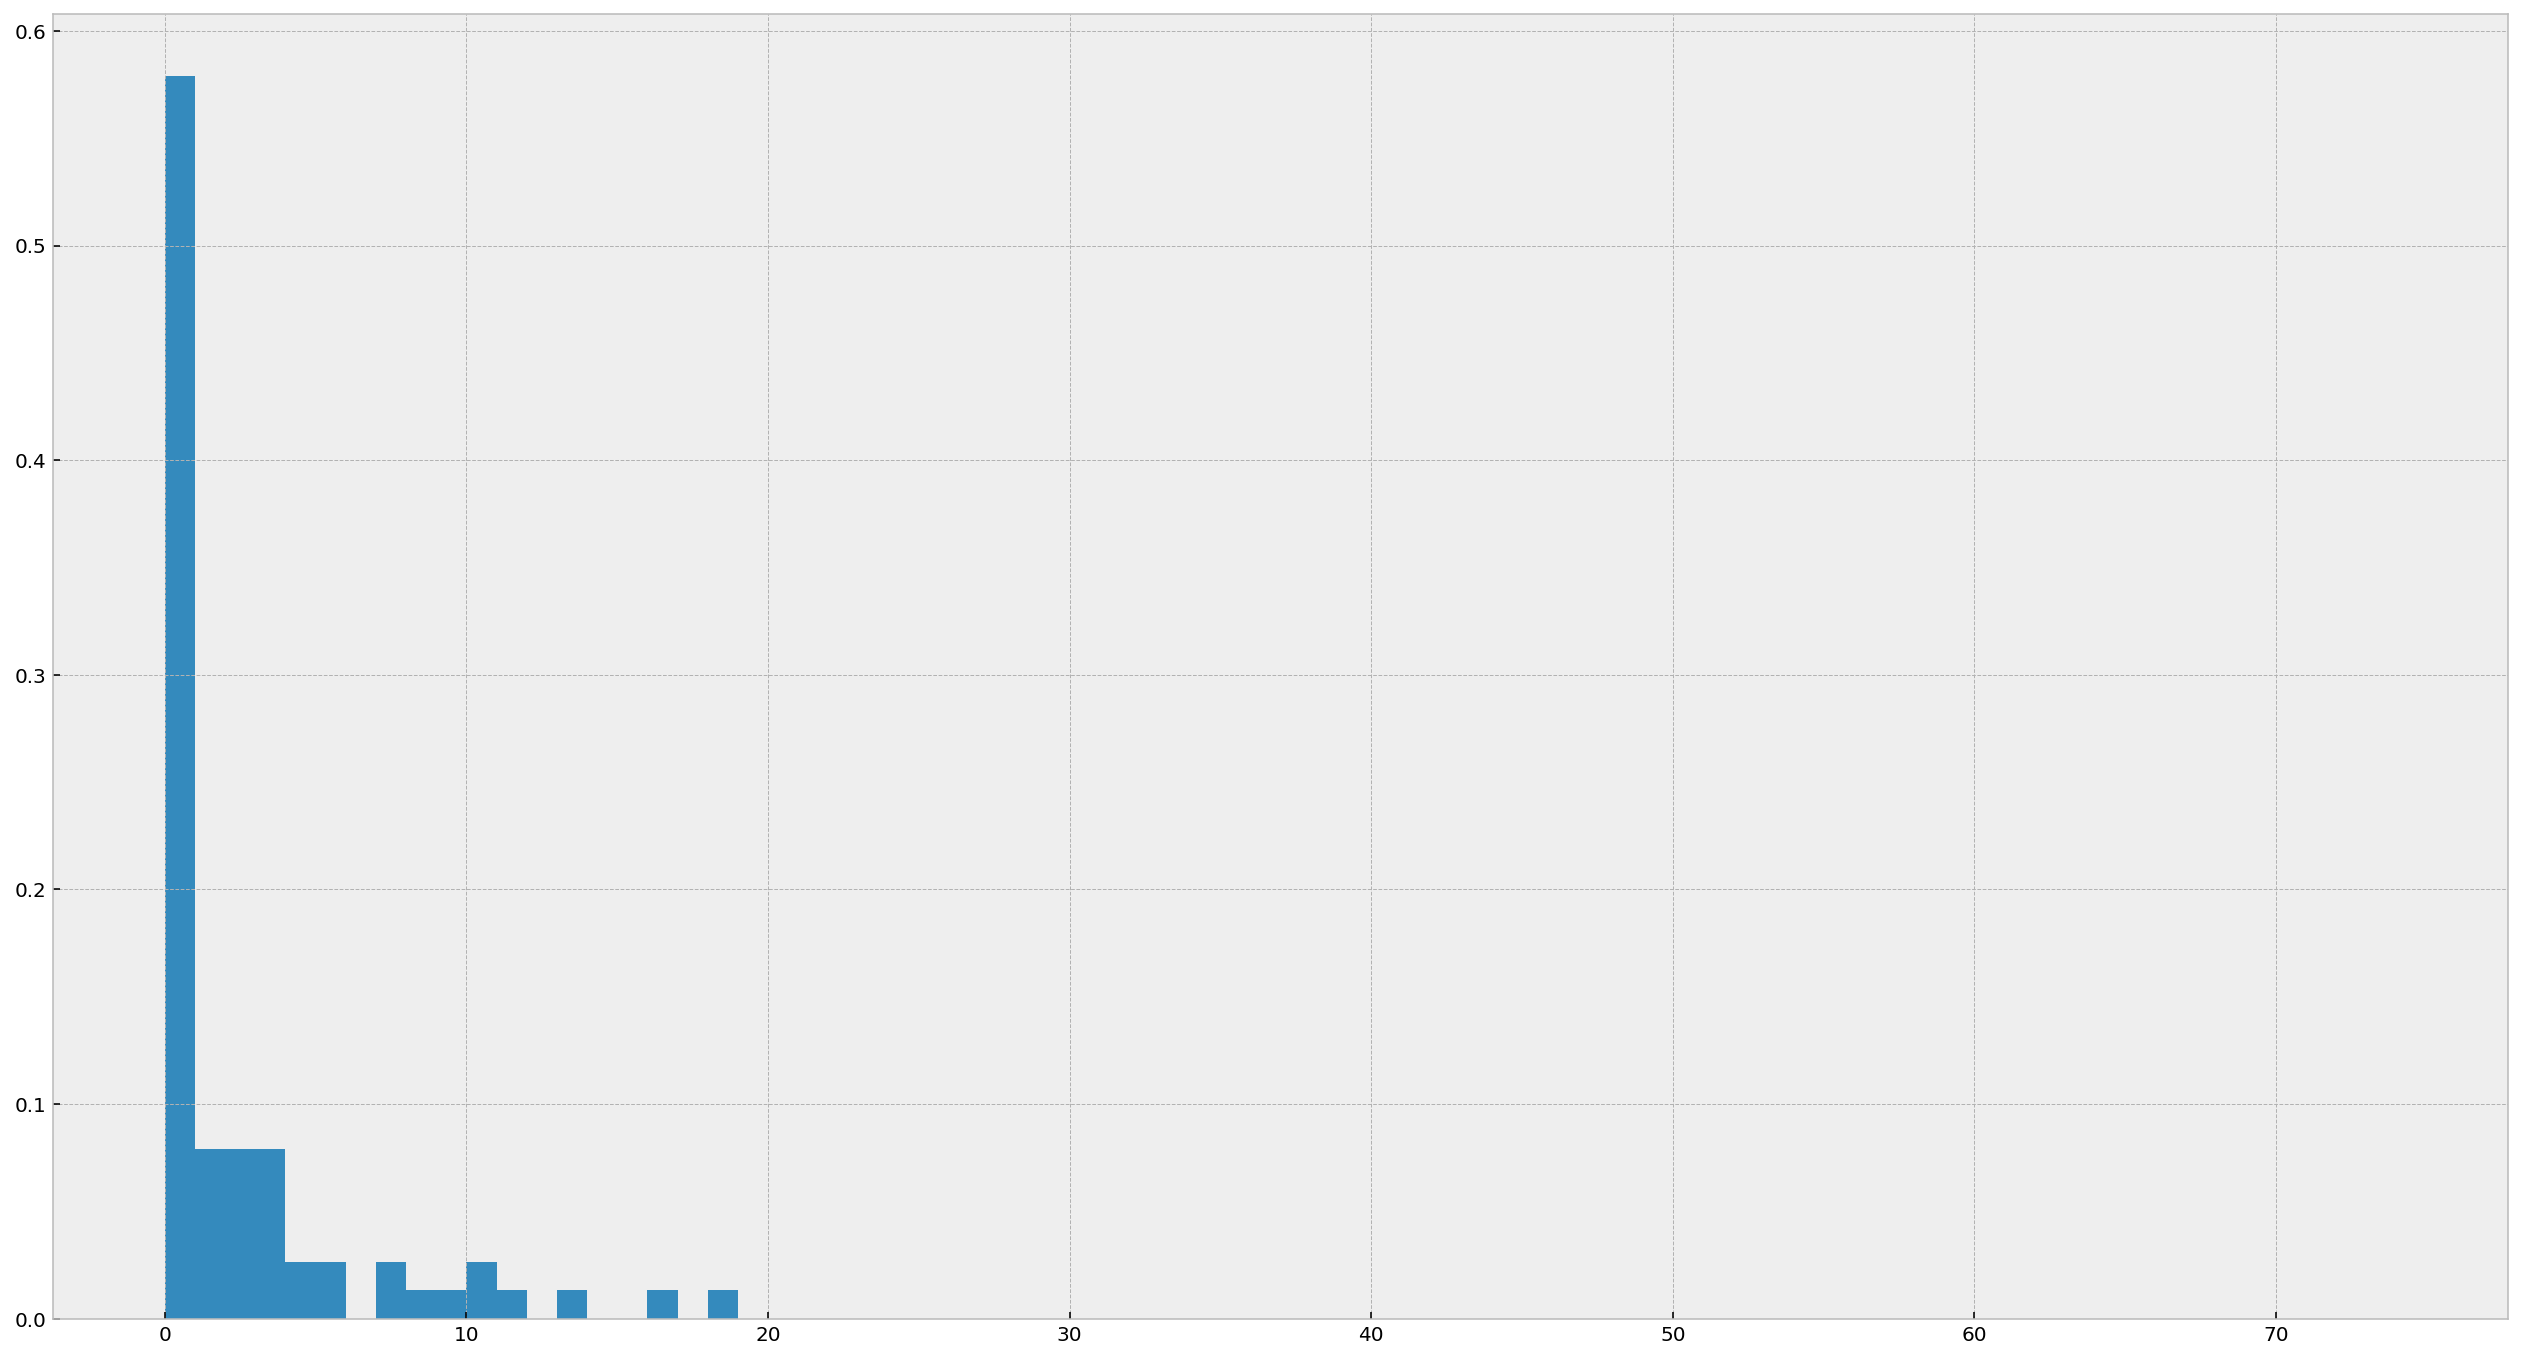

In [7]:
counts_obs = np.bincount(T)
T_obs = np.arange(np.amax(T))

#plt.rcParams["figure.figsize"] = (22,12)
plt.figure(figsize=(22,12))
ax = plt.hist(counts_obs, bins=T_obs, density=True)

ax.set_title('Histogram of observed durations', fontsize=40, pad=30)
#ax.set_xlabel('days', fontsize=30, labelpad=20); ax.set_ylabel('Overal Survival', fontsize=30, labelpad=20)
#ax.tick_params(axis="x", labelsize=25, rotation=45); ax.tick_params(axis="y", labelsize=25, rotation=45)
plt.xlim(0, 100)

In [11]:
from autograd.scipy.stats import norm
from lifelines.fitters import ParametricUnivariateFitter

class UpperAsymptoteFitter(ParametricUnivariateFitter):
    _fitted_parameter_names = ["c_", "mu_", "sigma_"]
    _bounds = ((0, None), (None, None), (0, None))
    def _cumulative_hazard(self, params, times):
        c, mu, sigma = params
        return c * norm.cdf((times - mu) / sigma, loc=0, scale=1)

uaf = UpperAsymptoteFitter().fit(T, E)

print("---")
print("Estimated lower bound: {:.2f} ({:.2f}, {:.2f})".format(
        np.exp(-uaf.summary.loc['c_', 'coef']),
        np.exp(-uaf.summary.loc['c_', 'coef upper 95%']),
        np.exp(-uaf.summary.loc['c_', 'coef lower 95%']),
    )
)

---
Estimated lower bound: 0.00 (0.00, inf)


C:\Users\alber\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
